In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

sns.set_theme()

In [2]:
import os

PLOT_DIR = "example-plots"

if not(os.path.exists(PLOT_DIR)):
    os.mkdir(PLOT_DIR)

In [3]:
THESIS_DIR = "results"

if not(os.path.exists(THESIS_DIR)):
    raise Error("Set the correct thesis root dir to save results to!")

THESIS_FIGURE_DIR = os.path.join(THESIS_DIR, "fig")
THESIS_TABLE_DIR = os.path.join(THESIS_DIR, "tab")

os.makedirs(THESIS_FIGURE_DIR, exist_ok=True)
os.makedirs(THESIS_TABLE_DIR, exist_ok=True)

In [5]:
def optlevel_to_label(level: str):
    o = int(level)
    if o <= 2:
        return "off"
    elif o == 3:
        return "off+inlining"
    elif o == 4:
        return "on"
    elif o == 5:
        return "on+inlining"

In [6]:
import json

def read_json(path):
    data = list()
    columns = [
        "Benchmark", 
        "Mode", 
        "Threads", 
        "Samples", 
        "Score", 
        "Score Error (99.9%)", 
        "Unit", 
        "Param: optimisationLevel", 
        "Param: problemSize", 
        "Param: sharedConstructors", 
        "Param: switchImplementation"
    ]
    
    with open(path, 'r') as f:
        for row in json.load(f):
            params = row["params"]
            problemSize = params.get("problemSize", "-1")
            for score in row["primaryMetric"]["rawData"][0]:
                x = [
                    row["benchmark"], 
                    row["mode"], 
                    row["threads"], 
                    1, 
                    score, 
                    "", 
                    row["primaryMetric"]["scoreUnit"], 
                    params["optimisationLevel"], 
                    problemSize, 
                    params["sharedConstructors"], 
                    params["switchImplementation"]
                ]
                data.append(x)
    df = pd.DataFrame(data, columns=columns)
    df["Param: optimisationLevel"] = df["Param: optimisationLevel"].astype("int")
    df["Param: problemSize"] = df["Param: problemSize"].astype("int")
    return df

In [7]:
# Load data
results_files = [
    "20221010-093719_.json",
    # "20220624-114836 .json",
    # "20220809-122119_benchmarktil.json",
    # "20220113-094204 chocopy.csv",
    # "20220113-224422 -f 1.csv"
    # "20211229-180617 chocopy.csv"
    # "20211117-210600 chocopy.csv"
#     "20211014-124146 -p optimisationLevel=4 -f 2 -wi 2 -i 3 run.csv",
#     "20211013-114213_results-compilespace.csv"
#     "20211013-114213_results-compilespace.csv"
#     "20211013-124531-benchnullary.csv"
#     "20211012-102647.csv"
#     "20211007-135249.csv",
#     "20211007-084741.csv", # benchsym switch backend
#     "20211006-143434.csv", # more problem swtich backend
#     "20210915-111700.csv",
#     "results-compilespace.csv",
]

df_raw = pd.concat(map(lambda f: pd.read_csv(f"results/{f}"), results_files), ignore_index=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Benchmark                  990 non-null    object 
 1   Mode                       990 non-null    object 
 2   Threads                    990 non-null    int64  
 3   Samples                    990 non-null    int64  
 4   Score                      990 non-null    float64
 5   Score Error (99.9%)        990 non-null    object 
 6   Unit                       990 non-null    object 
 7   Pattern Match Compilation  990 non-null    int64  
 8   Problem Size               990 non-null    int64  
 9   Shared Constructors        990 non-null    object 
 10  Codegen Implementation     990 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 85.2+ KB


In [8]:
for col in ["Score", "Score Error (99.9%)"]:
    if col in df_raw and df_raw[col].dtype == object:
        df_raw[col] = df_raw[col].map(lambda s: s.replace(',', '.'), na_action="ignore").astype(float)

# df_raw

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Pattern Match Compilation,Problem Size,Shared Constructors,Codegen Implementation
0,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,1,0.537814,,s/op,off+inlining,-1,on,
1,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,1,0.515967,,s/op,off+inlining,-1,on,
2,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,1,0.499112,,s/op,off+inlining,-1,on,
3,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,1,0.440359,,s/op,off+inlining,-1,on,
4,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,1,0.435272,,s/op,off+inlining,-1,on,
...,...,...,...,...,...,...,...,...,...,...,...
985,benchmark.til.execution.Factorial.run,ss,1,1,0.029969,,s/op,on,9,on,hash-switch
986,benchmark.til.execution.Factorial.run,ss,1,1,0.042087,,s/op,on,9,on,hash-switch
987,benchmark.til.execution.Factorial.run,ss,1,1,0.023703,,s/op,on,9,on,hash-switch
988,benchmark.til.execution.Factorial.run,ss,1,1,0.030208,,s/op,on,9,on,hash-switch


In [9]:
df_raw["Param: optimisationLevel"] = df_raw["Param: optimisationLevel"].astype("string")

In [10]:
df = df_raw[df_raw.Benchmark.str.endswith("jfr") == False].copy()
df

Benchmark Mode  Threads  Samples  \
0    benchmark.stratego2.compilation.java.Benchexpr...   ss        1        1   
1    benchmark.stratego2.compilation.java.Benchexpr...   ss        1        1   
2    benchmark.stratego2.compilation.java.Benchexpr...   ss        1        1   
3    benchmark.stratego2.compilation.java.Benchexpr...   ss        1        1   
4    benchmark.stratego2.compilation.java.Benchexpr...   ss        1        1   
..                                                 ...  ...      ...      ...   
985              benchmark.til.execution.Factorial.run   ss        1        1   
986              benchmark.til.execution.Factorial.run   ss        1        1   
987              benchmark.til.execution.Factorial.run   ss        1        1   
988              benchmark.til.execution.Factorial.run   ss        1        1   
989              benchmark.til.execution.Factorial.run   ss        1        1   

        Score Score Error (99.9%)  Unit Pattern Match Compilation  \
0    0.537814                      s/op              off+inlining   
1    0.515967                      s/op              off+inlining   
2    0.499112                      s/op              off+inlining   
3    0.440359                      s/op              off+inlining   
4    0.435272                      s/op              off+inlining   
..        ...                 ...   ...                       ...   
985  0.029969                      s/op                        on   
986  0.042087                      s/op                        on   
987  0.023703                      s/op                        on   
988  0.030208                      s/op                        on   
989  0.024044                      s/op                        on   

     Problem Size Shared Constructors Codegen Implementation  
0              -1                  on                         
1              -1                  on                         
2              -1                  on                         
3              -1                  on                         
4              -1                  on                         
..            ...                 ...                    ...  
985             9                  on            hash-switch  
986             9                  on            hash-switch  
987             9                  on            hash-switch  
988             9                  on            hash-switch  
989             9                  on            hash-switch  

[990 rows x 11 columns]

In [11]:
df["Stage"] = df["Benchmark"].str.rpartition('.')[2]
df["Problem"] = df["Benchmark"].str.split('.').map(lambda l: l[-2])
df

Benchmark Mode  Threads  Samples  \
0    benchmark.stratego2.compilation.java.Benchexpr...   ss        1        1   
1    benchmark.stratego2.compilation.java.Benchexpr...   ss        1        1   
2    benchmark.stratego2.compilation.java.Benchexpr...   ss        1        1   
3    benchmark.stratego2.compilation.java.Benchexpr...   ss        1        1   
4    benchmark.stratego2.compilation.java.Benchexpr...   ss        1        1   
..                                                 ...  ...      ...      ...   
985              benchmark.til.execution.Factorial.run   ss        1        1   
986              benchmark.til.execution.Factorial.run   ss        1        1   
987              benchmark.til.execution.Factorial.run   ss        1        1   
988              benchmark.til.execution.Factorial.run   ss        1        1   
989              benchmark.til.execution.Factorial.run   ss        1        1   

        Score Score Error (99.9%)  Unit Pattern Match Compilation  \
0    0.537814                      s/op              off+inlining   
1    0.515967                      s/op              off+inlining   
2    0.499112                      s/op              off+inlining   
3    0.440359                      s/op              off+inlining   
4    0.435272                      s/op              off+inlining   
..        ...                 ...   ...                       ...   
985  0.029969                      s/op                        on   
986  0.042087                      s/op                        on   
987  0.023703                      s/op                        on   
988  0.030208                      s/op                        on   
989  0.024044                      s/op                        on   

     Problem Size Shared Constructors Codegen Implementation        Stage  \
0              -1                  on                         compileJava   
1              -1                  on                         compileJava   
2              -1                  on                         compileJava   
3              -1                  on                         compileJava   
4              -1                  on                         compileJava   
..            ...                 ...                    ...          ...   
985             9                  on            hash-switch          run   
986             9                  on            hash-switch          run   
987             9                  on            hash-switch          run   
988             9                  on            hash-switch          run   
989             9                  on            hash-switch          run   

       Problem  
0    Benchexpr  
1    Benchexpr  
2    Benchexpr  
3    Benchexpr  
4    Benchexpr  
..         ...  
985  Factorial  
986  Factorial  
987  Factorial  
988  Factorial  
989  Factorial  

[990 rows x 13 columns]

In [12]:
import re
import os

# Add number of unique constructors to problems [J: Doesn't seem to work]
# cons_regex_pat = r"\bconstructors\b\W*(?:\s*(\w*)\s*:.*\s*)*\W*\brules\b"

cons_area_regex = r"^\s*constructors\s*$((?:.*\n)*)^\s*rules\s*$"
cons_area_pat = re.compile(cons_area_regex, re.MULTILINE)

cons_regex = r"\w+\s*:.*\S"
cons_pat = re.compile(cons_regex)

def find_constructors(p):
    cons_areas = cons_area_pat.findall(p)
    cons_groups = list(map(cons_pat.findall, cons_areas))
    conses = set().union(*cons_groups)
    return conses

def count_constructors_in_file(program_name):
    p_program = os.path.join("..", "src", "main", "resources", "stratego2", program_name + ".str2")
    try:
        with open(p_program, 'r') as f_program:
            contents = f_program.read()
            conses = find_constructors(contents)
            return len(conses)
    except:
        return np.nan

df["Number of constructors"] = (df["Problem"].str.lower() + df["Param: problemSize"].astype("str").mask(df["Param: problemSize"]==-1, "")).map(count_constructors_in_file)

In [13]:
## Plot-specific settings
configs = [
    {
        "problems": {"Benchexpr", "Benchsym", "Benchtree", "Bubblesort", "Factorial", "Fibonacci", "Hanoi", "Mergesort", "Quicksort", "Sieve"},
        "stages": {"run"},
        "settings": {"yscale": "log"}
    },
    {
        # Apply to all problems
        "stages": {"compileStratego", "compileJava", "Java space", "Class space"},
        "settings": {"ylim": (0, None)}
    },
    {
        "stages": {"Java space", "Class space"},
        "settings": {"ylabel": "Size (bytes)"}
    }
]

In [14]:
from pandas.core.common import flatten

def configure_grid(g: sns.FacetGrid, problem=None):
    ## Global settings
    g.set_ylabels("Time (s)")
    g.set_xlabels("Input size")

    for ax in flatten(g.axes):
        ax.get_xaxis().set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

    # Specific settings
    try:
        for (row_val, col_val), ax in g.axes_dict.items():
            for config in configs:
                if "problems" not in config or row_val in config["problems"]:
                    if "stages" not in config or col_val in config["stages"]:
                        ax.set(**config["settings"])
    except (ValueError):
        for col_val, ax in g.axes_dict.items():
            for config in configs:
                if "problems" not in config or problem in config["problems"]:
                    if "stages" not in config or col_val in config["stages"]:
                        ax.set(**config["settings"])
    finally:
        return g

In [20]:
df_scaledproblem = df[df["Benchmark"].str.contains("stratego") & (df["Problem Size"] != -1) & (df["Problem"] != "BenchNullary")]

In [21]:
df_scaledproblem[(df_scaledproblem["Problem"] == "Fibonacci")]

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Pattern Match Compilation,Problem Size,Shared Constructors,Codegen Implementation,Stage,Problem,Number of constructors
540,benchmark.stratego2.execution.Fibonacci.run,ss,1,1,1.649036,,s/op,off+inlining,18,on,,run,Fibonacci,NaN
541,benchmark.stratego2.execution.Fibonacci.run,ss,1,1,1.416276,,s/op,off+inlining,18,on,,run,Fibonacci,NaN
542,benchmark.stratego2.execution.Fibonacci.run,ss,1,1,1.441207,,s/op,off+inlining,18,on,,run,Fibonacci,NaN
543,benchmark.stratego2.execution.Fibonacci.run,ss,1,1,1.408788,,s/op,off+inlining,18,on,,run,Fibonacci,NaN
544,benchmark.stratego2.execution.Fibonacci.run,ss,1,1,1.352794,,s/op,off+inlining,18,on,,run,Fibonacci,NaN
545,benchmark.stratego2.execution.Fibonacci.run,ss,1,1,3.217557,,s/op,off+inlining,19,on,,run,Fibonacci,NaN
546,benchmark.stratego2.execution.Fibonacci.run,ss,1,1,3.145651,,s/op,off+inlining,19,on,,run,Fibonacci,NaN
547,benchmark.stratego2.execution.Fibonacci.run,ss,1,1,3.129957,,s/op,off+inlining,19,on,,run,Fibonacci,NaN
548,benchmark.stratego2.execution.Fibonacci.run,ss,1,1,2.970527,,s/op,off+inlining,19,on,,run,Fibonacci,NaN
549,benchmark.stratego2.execution.Fibonacci.run,ss,1,1,2.838755,,s/op,off+inlining,19,on,,run,Fibonacci,NaN


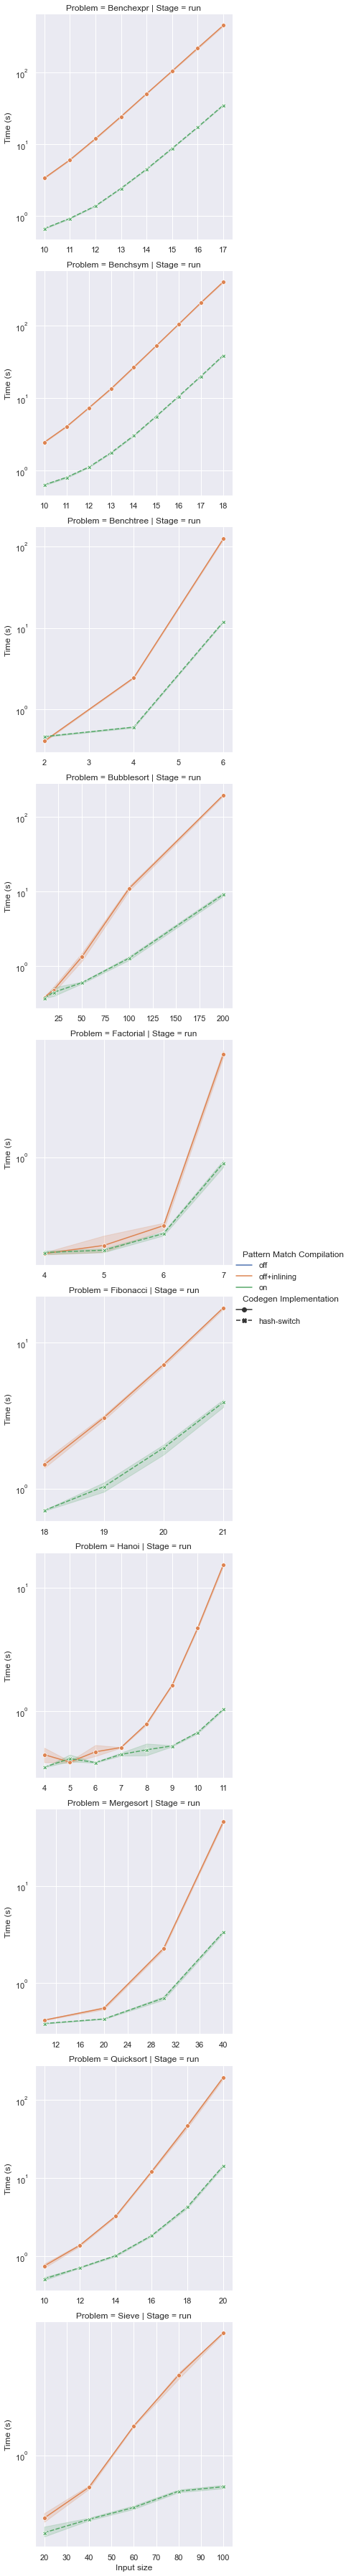

In [22]:
g = configure_grid(sns.relplot(
    data=df_scaledproblem,
    x="Param: problemSize",
    y="Score",
    row="Problem",
    row_order=np.sort(np.unique(df_scaledproblem["Problem"].values)),
    col="Stage",
    col_order=[s for s in ["compileStratego", "Java space", "compileJava", "Class space", "run"] if s in df_scaledproblem["Stage"].values],
    style="Param: switchImplementation",
    hue="Param: optimisationLevel",
    hue_order=["2", "3", "4"],
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

# TODO Include strj runtime -> with and without fusion

# Save figure to file
plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-allstages.png")

In [17]:
# g = configure_grid(sns.relplot(
#     data=df_scaledproblem,
#     x="Problem Size",
#     y="Score",
#     row="Problem",
#     row_order=np.sort(np.unique(df_scaledproblem["Problem"].values)),
#     col="Stage",
#     col_order=[s for s in ["compileStratego", "Java space", "compileJava", "Class space", "run"] if s in df_scaledproblem["Stage"].values],
#     style="Codegen Implementation",
#     hue="Pattern Match Compilation",
#     hue_order=map(optlevel_to_label, ["2", "3", "4"]),
#     kind="line",
# #     err_style="band",
#     markers=True,
#     facet_kws=dict(
#         sharex=False, 
#         sharey=False,
#     ),
# ))

# # TODO Include strj runtime -> with and without fusion

# # Save figure to file
# plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-allstages.png")

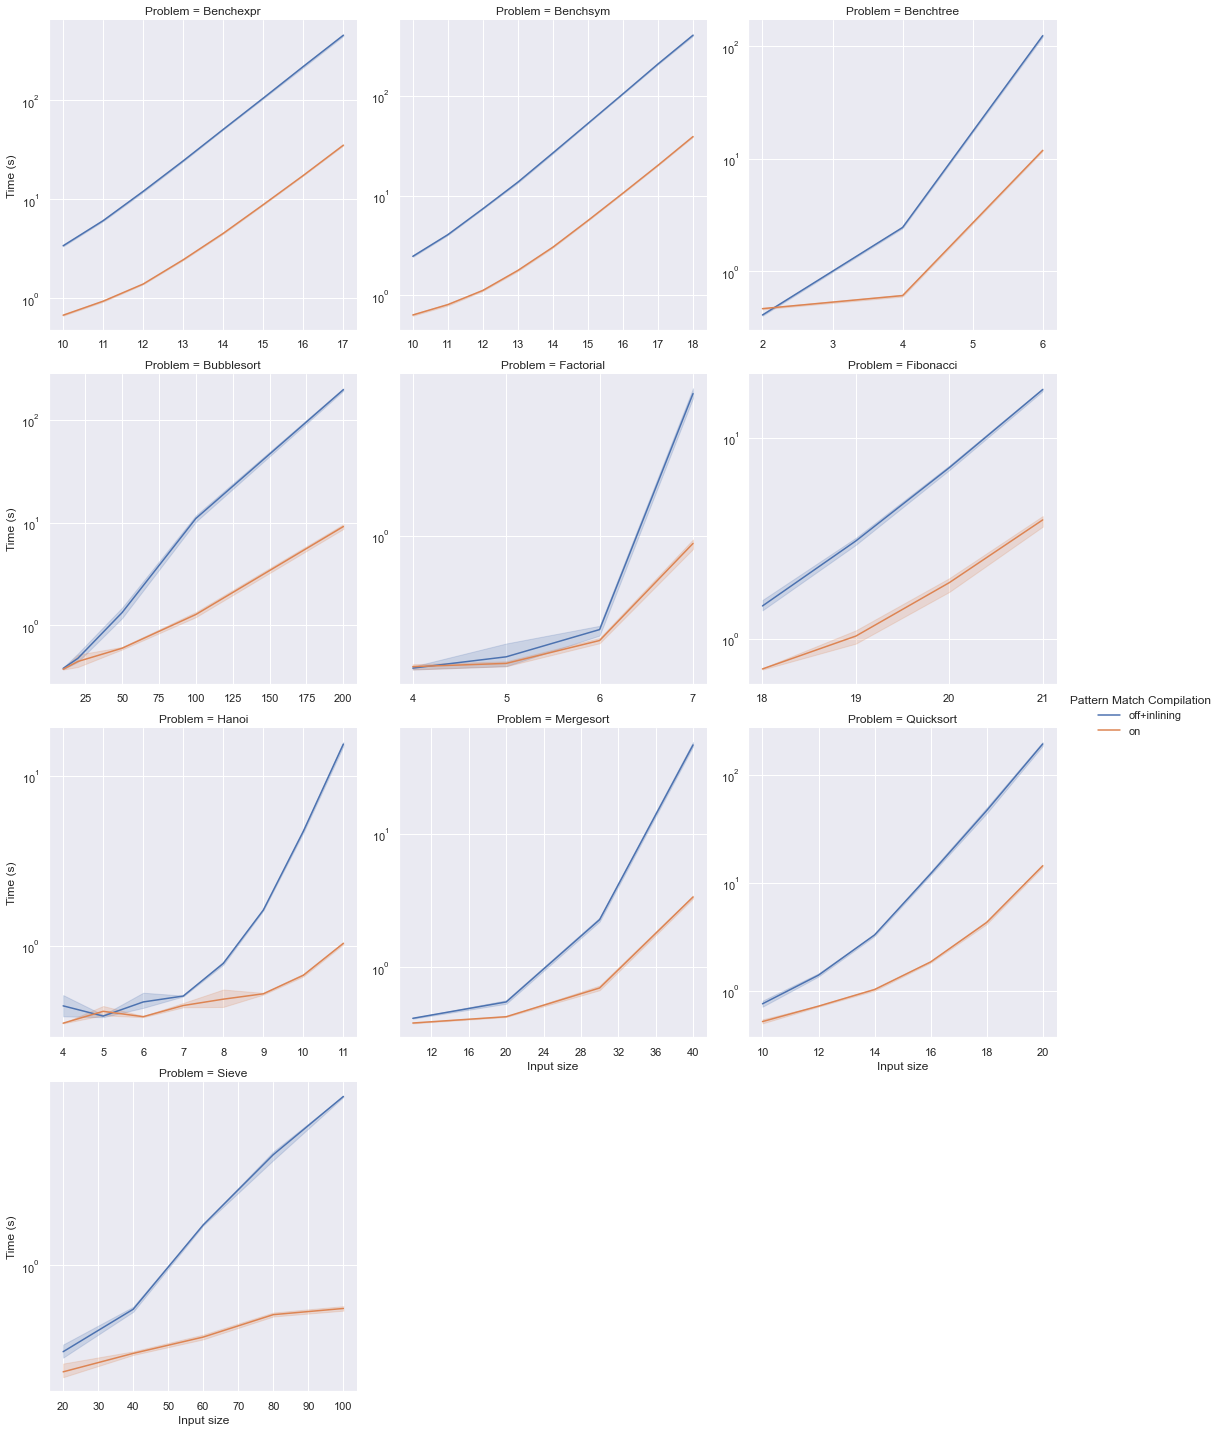

In [24]:
# Runtimes for DFA switch backends (per problem)

cols = np.sort(np.unique(df_scaledproblem["Problem"].values))

g = configure_grid(sns.relplot(
    data=df_scaledproblem[(df_scaledproblem["Problem Size"] != -1) & (df_scaledproblem["Stage"] == "run") & (df_scaledproblem["Pattern Match Compilation"].isin(opt_levels))],
    x="Problem Size",
    y="Score",
    col="Problem",
    col_order=cols,
    col_wrap=min(3, len(cols)),
#     style="Codegen Implementation",
    hue="Pattern Match Compilation",
    hue_order=opt_levels,
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

g.set(yscale="log")

# TODO Include strj runtime -> with and without fusion

# Save figure to file
plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-runtime.png")

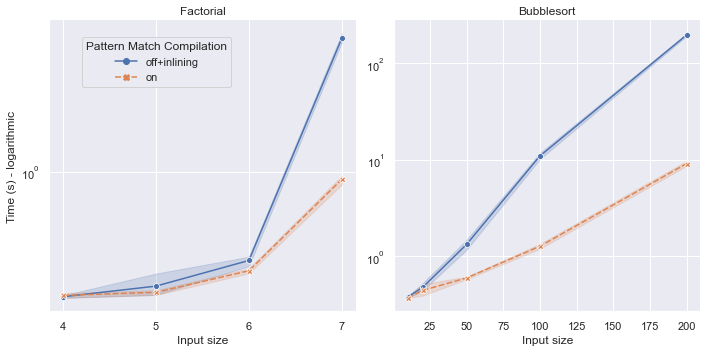

In [25]:
# Runtimes for DFA switch backends (per problem)

cols = ["Factorial", "Bubblesort"]
opt_levels=list(map(optlevel_to_label, ["3", "4"]))

g = configure_grid(sns.relplot(
    data=df_scaledproblem[(df_scaledproblem["Stage"] == "run") & (df_scaledproblem["Pattern Match Compilation"].isin(opt_levels))],
    x="Problem Size",
    y="Score",
    col="Problem",
    col_order=cols,
    col_wrap=min(3, len(cols)),
    style="Pattern Match Compilation",
    hue="Pattern Match Compilation",
    hue_order=opt_levels,
    kind="line",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

sns.move_legend(g, "upper left", frameon=True, bbox_to_anchor=(0.1, 0.9))
g.set(yscale="log")
g.set_titles(None, None, "{col_name}")
g.set_axis_labels("Input size", "Time (s) - logarithmic")

# TODO Include strj runtime -> with and without fusion

# Save figure to file
g.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-fact&bub-run.pdf")
# g.savefig(f"{THESIS_FIGURE_DIR}/rec-fact&fib-run.pdf")

/var/folders/yh/005cg_5s02b63kq3xy2lfyfh0000gn/T/ipykernel_86601/643155783.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_til_add["Problem Size"] = df_til_add["Problem"].str[3:].astype("int")
/var/folders/yh/005cg_5s02b63kq3xy2lfyfh0000gn/T/ipykernel_86601/643155783.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_til_add["Stage"] = df_til_add["Stage"].map(lambda s: "Interpret" if s == "run" else "Optimise" if s == "runTILCompiler" else s )


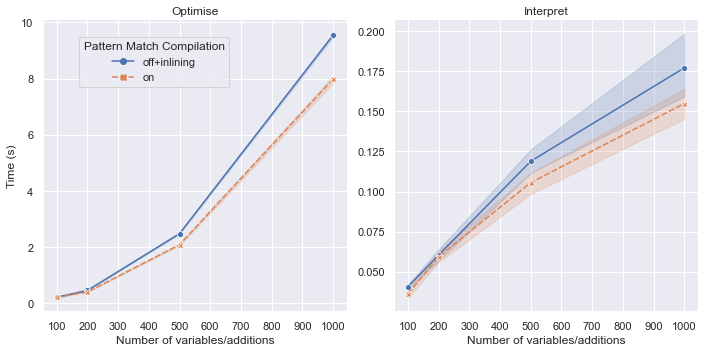

In [26]:
# Runtimes for DFA switch backends (per problem)
opt_levels=list(map(optlevel_to_label, ["3", "4"]))

df_til_add = df[df["Benchmark"].str.contains("til") & df["Problem"].str.contains("Add")]
df_til_add["Problem Size"] = df_til_add["Problem"].str[3:].astype("int")
df_til_add["Stage"] = df_til_add["Stage"].map(lambda s: "Interpret" if s == "run" else "Optimise" if s == "runTILCompiler" else s )

g = configure_grid(sns.relplot(
    data=df_til_add,
    x="Problem Size",
    y="Score",
    col="Stage",
    col_wrap=min(3, len(cols)),
    style="Pattern Match Compilation",
    hue="Pattern Match Compilation",
    hue_order=opt_levels,
    kind="line",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

sns.move_legend(g, "upper left", frameon=True, bbox_to_anchor=(0.1, 0.9))
# g.set(yscale="log")
g.set_titles(None, None, "{col_name}")
g.set_axis_labels("Number of variables/additions", "Time (s)")

# TODO Include strj runtime -> with and without fusion

# Save figure to file
g.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-til.pdf")
# g.savefig(f"{THESIS_FIGURE_DIR}/rec-fact&fib-run.pdf")

In [27]:
# Runtimes for DFA switch backends (per problem)

cols = ["Factorial", "Fibonacci"]
opt_levels=list(map(optlevel_to_label, ["3", "4"]))

g = configure_grid(sns.relplot(
    data=df_scaledproblem[(df_scaledproblem["Stage"] == "compileStratego") & (df_scaledproblem["Pattern Match Compilation"].isin(opt_levels))],
    x="Problem Size",
    y="Score",
    col="Problem",
    col_order=cols,
    col_wrap=min(3, len(cols)),
    style="Codegen Implementation",
    hue="Pattern Match Compilation",
    hue_order=opt_levels,
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

g.set(ylim=(0, None))

# TODO Include strj runtime -> with and without fusion

# Save figure to file
g.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-fact&fib-compileStratego.png")
# g.savefig(f"{THESIS_FIGURE_DIR}/rec-fact&fib-compileStratego.pdf")

ValueError: Number of rows must be a positive integer, not 0

<Figure size 720x0 with 0 Axes>

In [28]:
df_scaledproblem[(df_scaledproblem["Stage"] == "run") & (df_scaledproblem["Problem"] == "Sieve") & (df_scaledproblem["Problem Size"] == 100)]

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Pattern Match Compilation,Problem Size,Shared Constructors,Codegen Implementation,Stage,Problem,Number of constructors
790,benchmark.stratego2.execution.Sieve.run,ss,1,1,4.128471,,s/op,off+inlining,100,on,,run,Sieve,NaN
791,benchmark.stratego2.execution.Sieve.run,ss,1,1,4.084278,,s/op,off+inlining,100,on,,run,Sieve,NaN
792,benchmark.stratego2.execution.Sieve.run,ss,1,1,4.126164,,s/op,off+inlining,100,on,,run,Sieve,NaN
793,benchmark.stratego2.execution.Sieve.run,ss,1,1,4.116436,,s/op,off+inlining,100,on,,run,Sieve,NaN
794,benchmark.stratego2.execution.Sieve.run,ss,1,1,4.065365,,s/op,off+inlining,100,on,,run,Sieve,NaN
815,benchmark.stratego2.execution.Sieve.run,ss,1,1,0.696866,,s/op,on,100,on,hash-switch,run,Sieve,NaN
816,benchmark.stratego2.execution.Sieve.run,ss,1,1,0.678054,,s/op,on,100,on,hash-switch,run,Sieve,NaN
817,benchmark.stratego2.execution.Sieve.run,ss,1,1,0.680319,,s/op,on,100,on,hash-switch,run,Sieve,NaN
818,benchmark.stratego2.execution.Sieve.run,ss,1,1,0.713157,,s/op,on,100,on,hash-switch,run,Sieve,NaN
819,benchmark.stratego2.execution.Sieve.run,ss,1,1,0.713369,,s/op,on,100,on,hash-switch,run,Sieve,NaN


In [29]:
df_ratios = df[df["Stage"] == "run"].pivot(index=["Param: switchImplementation"], columns=["Benchmark", "Param: problemSize", "Number of constructors", "Problem"], values="Score").T

# df_ratios["Ratio"] = df_ratios["elseif"] / df_ratios["switch"]
df_ratios["Ratio [nested]"] = df_ratios["nested-switch"] / df_ratios["elseif"]
df_ratios["Ratio [hash]"] = df_ratios["hash-switch"] / df_ratios["elseif"]

df_ratios.sort_values("Ratio [hash]")

# df_ratios.columns.to_series().apply(''.join)

# df[df[""]]

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
df_ratios_flat = df_ratios.melt(value_vars=["Ratio [hash]"], value_name="Ratio", ignore_index=False)
# df_ratios_flat.index = df_ratios_flat.index.to_flat_index()
# df_ratios_flat.reset_index()
df_ratios_flat.index

In [30]:
# df_ratios.melt(id_

In [31]:
# Runtimes for DFA switch backends (against number of constructors)

g = configure_grid(sns.relplot(
    data=df_ratios,
    x="Number of constructors",
    y="Ratio [hash]",
    style="Problem",
    hue="Problem",
    size="Param: problemSize",
    kind="scatter",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

# g.set(yscale="log")
g.set_ylabels("Ratio of runtime [hash-switch] over runtime [elseif]")
g.set_xlabels("# of constructors in program")

# TODO Include strj runtime -> with and without fusion

# Save figure to file
plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-backend-constructors.png")

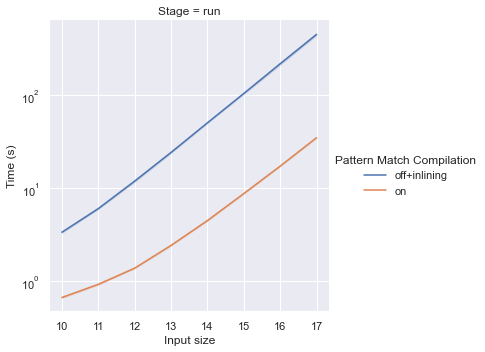

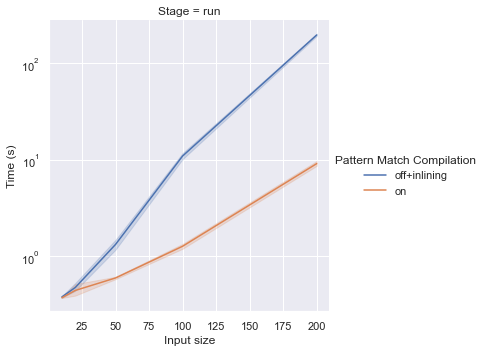

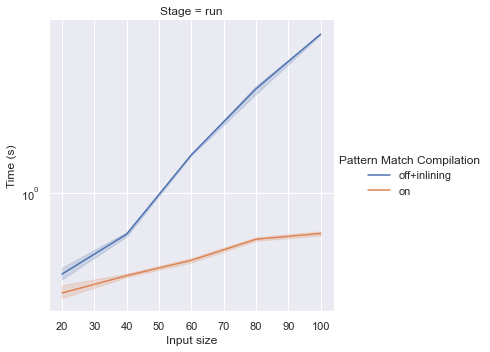

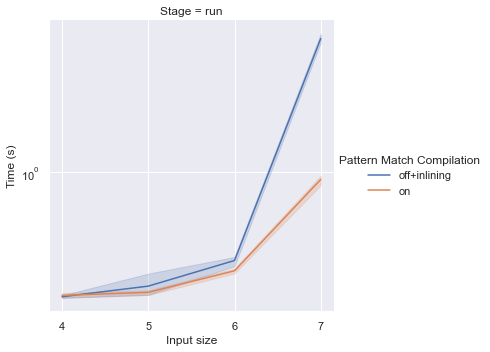

In [32]:
for problem in ["Benchexpr", "Bubblesort", "Sieve", "Factorial"]:
    df_problem = df_scaledproblem[df_scaledproblem["Problem"] == problem]
    
    cols = [s for s in ["compileStratego", "compileJava", "run", "Java space", "Class space"] if s in df_problem["Stage"].values]

    g = configure_grid(sns.relplot(
        data=df_problem,
        x="Param: problemSize",
        y="Score",
#         row="Problem",
#         row_order=np.sort(np.unique(df_problem["Problem"].values)),
        col_wrap=min(3, len(cols)),
        col="Stage",
        col_order=cols,
#        style="Codegen Implementation",
        hue="Pattern Match Compilation",
        hue_order=[l for l in map(optlevel_to_label, ["3", "4"]) if l in df_problem["Pattern Match Compilation"].values],
        kind="line",
    #     err_style="band",
        markers=True,
        facet_kws=dict(
            sharex=False, 
            sharey=False,
        ),
    ), problem)

    # Save figure to file
    g.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-{problem}.pdf")
    # g.savefig(f"{THESIS_FIGURE_DIR}/rec-{problem}-stages.pdf")

In [45]:
df_unscaledproblem = df[df["Problem Size"] == -1]

data = df_unscaledproblem.loc[
            df_unscaledproblem["Benchmark"].str.contains("stratego")].copy()
                # & ((df_unscaledproblem["Pattern Match Compilation"] == optlevel_to_label("2"))
                #     | (df_unscaledproblem["Codegen Implementation"] == "hash-switch"))].copy()

data2 = pd.DataFrame()

for problem, df_problem in data.groupby("Problem"):
    for stage, df_p_stage in df_problem.groupby("Stage"):
        median = df_p_stage[df_p_stage["Codegen Implementation"] == ""]["Score"].median()
        data2 = pd.concat([data2, df_p_stage.assign(MedianScore=lambda x: median)], ignore_index=True)
        
data2["Score"] = data2["Score"] / data2["MedianScore"]
data2

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Pattern Match Compilation,Problem Size,Shared Constructors,Codegen Implementation,Stage,Problem,Number of constructors,MedianScore
0,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,1,1.077542,,s/op,off+inlining,-1,on,,compileJava,Benchexpr,92.0,0.499112
1,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,1,1.033769,,s/op,off+inlining,-1,on,,compileJava,Benchexpr,92.0,0.499112
2,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,1,1.000000,,s/op,off+inlining,-1,on,,compileJava,Benchexpr,92.0,0.499112
3,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,1,0.882284,,s/op,off+inlining,-1,on,,compileJava,Benchexpr,92.0,0.499112
4,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,1,0.872092,,s/op,off+inlining,-1,on,,compileJava,Benchexpr,92.0,0.499112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,benchmark.stratego2.compilation.stratego.Sieve...,ss,1,1,1.656647,,s/op,on,-1,on,hash-switch,compileStratego,Sieve,40.0,1.116647
256,benchmark.stratego2.compilation.stratego.Sieve...,ss,1,1,1.352536,,s/op,on,-1,on,hash-switch,compileStratego,Sieve,40.0,1.116647
257,benchmark.stratego2.compilation.stratego.Sieve...,ss,1,1,1.337170,,s/op,on,-1,on,hash-switch,compileStratego,Sieve,40.0,1.116647
258,benchmark.stratego2.compilation.stratego.Sieve...,ss,1,1,1.218487,,s/op,on,-1,on,hash-switch,compileStratego,Sieve,40.0,1.116647


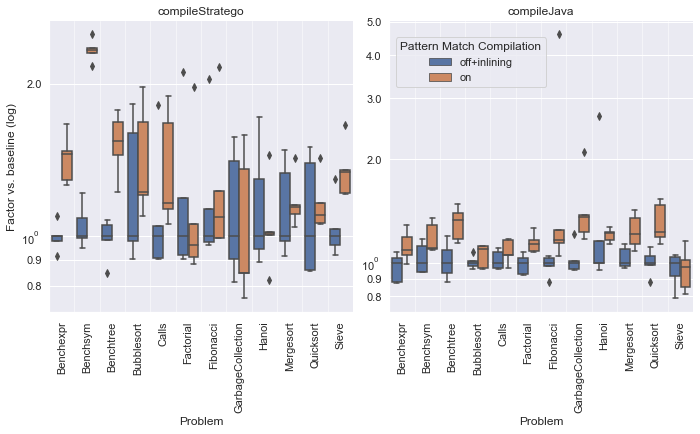

In [ ]:
from matplotlib import ticker

g = sns.catplot(
    data = data2,
    x = "Problem",
    y = "Score",
    col = "Stage",
    col_order = [s for s in ["compileStratego", "compileJava"] if s in df_unscaledproblem["Stage"].values],
    hue = "Pattern Match Compilation",
    kind = "box",
    sharey=False,
)

g.set_ylabels("Factor vs. baseline (log)")
for _, ax in g.axes_dict.items():
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=90)
    # ax.grid(True, 'major', 'y')
    ax.grid(True, 'minor', 'y')
    ax.set_xticks([s-0.5 for s in locs], minor=True)
    ax.grid(True, 'minor', 'x', alpha=0.5)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(1))
    ax.yaxis.set_minor_formatter(ticker.ScalarFormatter(1))
# plt.xticks(rotation=90)
sns.move_legend(g, "upper left", frameon=True, bbox_to_anchor=(0.47, 0.9))
g.set_titles(None, None, "{col_name}")

# g.map(plt.errorbar, "Problem", "Score", "Score Error (99.9%)", marker="o")
# g.map(plt.xticks, "Problem", "Score", rotation=90)

g.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-unscaled.pdf")
# g.savefig(f"{THESIS_FIGURE_DIR}/chocopy-alltimes.pdf")

# Experiments

In [144]:
def errorbar_pmc(x, y, err, pmc, **kwargs):
    for i in set(pmc):
        print(pmc == i)
        plt.errorbar(x[pmc == i], y[pmc == i], err[pmc == i])
        
def errorbar(x, y, err, *args, **kwargs):
    import itertools
    from functools import reduce
    
    print("kwargs: " + str(kwargs))
    for p in itertools.product(*map(lambda arg: set(arg), args)):
        print("p", p)
        
        ind = reduce(lambda acc, tp: acc & (args[tp[0]] == tp[1]), enumerate(p), [True] * len(x))
        
        plt.errorbar(x[ind], y[ind], err[ind], ecolor=None, capsize=5, **kwargs) # kwargs["color"]
        
        # for i, x in enumerate(p):
        #     print("i: " + str(i))
        #     print("x: " + str(x))
        #     print(args[i] == x)
        # print(x[pmc == i], y[pmc == i])
        # plt.errorbar(x[pmc == i], y[pmc == i], err[pmc == i], **kwargs)

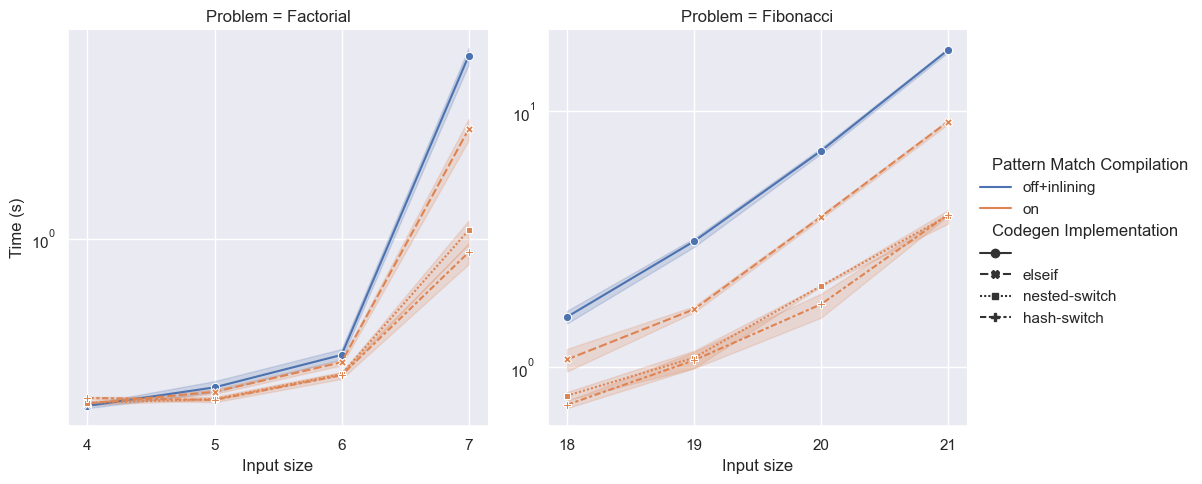

In [145]:
cols = ["Factorial", "Fibonacci"]
opt_levels=list(map(optlevel_to_label, ["3", "4"]))

g = configure_grid(sns.relplot(
    data=df_scaledproblem[(df_scaledproblem["Stage"] == "run") & (df_scaledproblem["Pattern Match Compilation"].isin(opt_levels))],
    x="Problem Size",
    y="Score",
    col="Problem",
    col_order=cols,
    # col_wrap=min(3, len(cols)),
    # row="Pattern Match Compilation",
    style="Codegen Implementation",
    hue="Pattern Match Compilation",
    hue_order=opt_levels,
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

g.set(yscale="log")

# g.map(errorbar, "Problem Size", "Score", "Score Error (99.9%)", "Pattern Match Compilation", "Codegen Implementation", "Problem")

In [146]:
df_scaledproblem[(df_scaledproblem["Problem"] == "Fibonacci") & (df_scaledproblem["Pattern Match Compilation"] == "off+inlining") & (df_scaledproblem["Stage"] == "run")]

Benchmark Mode  Threads  Samples  \
1580  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1581  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1582  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1583  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1584  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1585  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1586  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1587  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1588  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1589  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1590  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1591  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1592  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1593  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1594  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1595  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1596  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1597  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1598  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   
1599  benchmark.stratego2.execution.Fibonacci.run   ss        1        1   

          Score Score Error (99.9%)  Unit Pattern Match Compilation  \
1580   1.639650                      s/op              off+inlining   
1581   1.436740                      s/op              off+inlining   
1582   1.641367                      s/op              off+inlining   
1583   1.694761                      s/op              off+inlining   
1584   1.452431                      s/op              off+inlining   
1585   3.177150                      s/op              off+inlining   
1586   2.809666                      s/op              off+inlining   
1587   3.148621                      s/op              off+inlining   
1588   3.168560                      s/op              off+inlining   
1589   3.224466                      s/op              off+inlining   
1590   6.904515                      s/op              off+inlining   
1591   7.292810                      s/op              off+inlining   
1592   6.943275                      s/op              off+inlining   
1593   7.180613                      s/op              off+inlining   
1594   6.730181                      s/op              off+inlining   
1595  17.565141                      s/op              off+inlining   
1596  17.785479                      s/op              off+inlining   
1597  17.291829                      s/op              off+inlining   
1598  17.584954                      s/op              off+inlining   
1599  16.710348                      s/op              off+inlining   

      Problem Size Shared Constructors Codegen Implementation Stage  \
1580            18                  on                          run   
1581            18                  on                          run   
1582            18                  on                          run   
1583            18                  on                          run   
1584            18                  on                          run   
1585            19                  on                          run   
1586            19                  on                          run   
1587            19                  on                          run   
1588            19                  on                          run   
1589            19                  on                          run   
1590            20                  on                          run   
1591            20                  on                          run   
1592            20          

In [147]:
plt.errorbar

<function matplotlib.pyplot.errorbar(x, y, yerr=None, xerr=None, fmt='', ecolor=None, elinewidth=None, capsize=None, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None, *, data=None, **kwargs)>